In [1]:
import cv2
from CNN3 import DesNet
import torch
import numpy as np
import scipy
from scipy import optimize
import matplotlib.pyplot as plt

# Helper Functions

In [2]:
def getPatches(kps, img, size=32, num=200):
    res = torch.zeros(num, 1, size, size)
    if type(img) is np.ndarray:
        img = torch.from_numpy(img)
    h, w = img.shape      # note: for image, the x direction is the verticle, y-direction is the horizontal...
    for i in range(num):
        cx, cy = kps[i]
        cx, cy = int(cx), int(cy)
        dd = int(size/2)
        xmin, xmax = max(0, cx - dd), min(w, cx + dd ) 
        ymin, ymax = max(0, cy - dd), min(h, cy + dd ) 
        xmin_res, xmax_res = dd - min(dd,cx), dd + min(dd, w - cx)
        ymin_res, ymax_res = dd - min(dd,cy), dd + min(dd, h - cy)
        cropped_img = img[ymin: ymax, xmin: xmax]
        ch, cw = cropped_img.shape
        res[i, 0, ymin_res: ymin_res+ch, xmin_res: xmin_res+cw] =  cropped_img
    return res

def similarity(q_feats, r_feats):
    s_kl = np.zeros((len(q_feats), len(r_feats)))
    s_kl_val = 0
    for i, q_f in enumerate(q_feats):
        for j, r_f in enumerate(r_feats):
            simi = 0.5 * (1 + ((np.dot(q_f.T, r_f))/(np.linalg.norm(q_f, 2) * np.linalg.norm(r_f, 2))))
            s_kl[i][j] = simi
            s_kl_val += simi
    return s_kl, s_kl_val

def get_top_k(s_img_, k = 3):
    top_k = np.argsort(s_img_)[-k:]
    return top_k

def eval_(q_n, gt_dict, top_k):
    num_correct = 0
    for ids in top_k:
        if ids+1 in gt_dict["q{}".format(q_n + 1)]:
            num_correct += 1
    prec = num_correct/len(top_k)
    recall = num_correct/4
    return prec, recall

# Loading given model

In [3]:
model = DesNet() # Change to your model for the latter part of assignment
model.load_state_dict(torch.load('checkpoint.pth')["state_dict"])
model.cuda().eval()

DesNet(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (8): ReLU()
    (9): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (11): ReLU()
    (12): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (14): Re

# Loading Ground Truth Information

In [4]:
gt_dict = {}
with open('ground_truth.txt') as fp:
    lines = fp.readlines()
    for line in lines[2:-1]:
        q, r = line.split()
        try:
            gt_dict[q].append(int(r))
        except:
            gt_dict[q] = [int(r)]

# Load query images and compute keypoints and features

In [5]:
sift = cv2.xfeatures2d.SIFT_create(nfeatures=20)

q_imgs = []
for i in range(1, 35):
    img = cv2.imread('./query/q{}.JPG'.format(i))
    g_img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    keypoints, descriptors_1 = sift.detectAndCompute(g_img, None)
    keypoints = cv2.KeyPoint_convert(keypoints)[:20]
    patches = getPatches(keypoints, g_img,size=32, num=20)
    q_imgs.append(torch.as_tensor(patches))
q_imgs = torch.cat(q_imgs, dim=1).permute(1, 0, 2, 3)

# Compute features of keypoints
q_arr = np.zeros((len(q_imgs), 20, 128))
for i, x in enumerate(q_imgs): 
    out = model(x.unsqueeze(1).cuda())    
    q_arr[i] = out.squeeze().cpu().detach().numpy()
print(q_arr.shape)

(34, 20, 128)


# Load dataset images and compute keypoints and features

In [6]:
r_imgs = []
for i in range(1, 137):
    img = cv2.imread('./images/{}.JPG'.format(i))
    g_img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    keypoints, descriptors_1 = sift.detectAndCompute(g_img, None)
    keypoints = cv2.KeyPoint_convert(keypoints)[:20]
    patches = getPatches(keypoints, g_img,size=32, num=20)
    r_imgs.append(torch.as_tensor(patches))
r_imgs = torch.cat(r_imgs, dim=1).permute(1, 0, 2, 3)

r_arr = np.zeros((len(r_imgs), 20, 128))
for i, x in enumerate(r_imgs): 
    out = model(x.unsqueeze(1).cuda())    
    r_arr[i] = out.squeeze().cpu().detach().numpy()
print(r_arr.shape)

(136, 20, 128)


# Many-to-many matching

In [7]:
s_img_ = np.zeros((len(q_arr), len(r_arr)))

for i, q_f in enumerate(q_arr):
    for j, r_f in enumerate(r_arr):
        s_kl, s_kl_val = similarity(q_f, r_f)
        s_kl = s_kl.flatten()
        x_star = s_kl/np.sqrt(np.sum(np.square(s_kl)))
        top_30 = np.argsort(x_star)[-30:]
        sol = np.zeros((x_star.shape))
        sol[top_30] = 1
        s_img_[i][j] = np.dot(s_kl, sol)

# Compute Precision and Recall

In [8]:
top_1 = []
top_2 = []
top_3 = []
top_4 = []

for i in range(len(q_arr)):
    for k in range(1, 5):
        top_ids = get_top_k(s_img_[i], k)
        prec, recall = eval_(i, gt_dict, top_ids)
        exec("top_%s.append([%f, %f])" % (k, prec, recall))

In [9]:
for k in range(1, 5):
    exec("top_%davg = np.mean(np.array(top_%d), axis=0)" % (k, k))

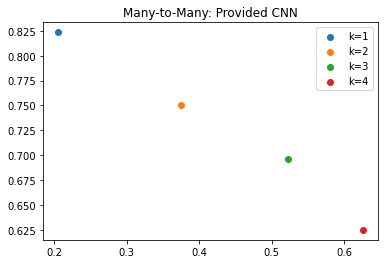

In [10]:
plt.figure()
for k in range(1, 5):
    exec("plt.scatter(top_%davg[1], top_%davg[0], label='k=%d')" % (k, k, k))    
plt.legend()
plt.title('Many-to-Many: Provided CNN')   
plt.show()

# One-to-One matching

In [11]:
s_img_ = np.zeros((len(q_arr), len(r_arr)))

for i, q_f in enumerate(q_arr):
    for j, r_f in enumerate(r_arr):
        s_kl, s_kl_val = similarity(q_f, r_f)
        res = scipy.optimize.linear_sum_assignment(1 - s_kl)
        x = np.zeros((20, 20))
        x[res] = 1
        cost = np.sum(s_kl*x)
        s_img_[i][j] = cost

# Compute Precision and Recall

In [12]:
top_1 = []
top_2 = []
top_3 = []
top_4 = []
for i in range(len(q_arr)):
    for k in range(1, 5):
        top_ids = np.argsort(s_img_[i])[-k:]
        prec, recall = eval_(i, gt_dict, top_ids)
        exec("top_%s.append([%f, %f])" % (k, prec, recall))

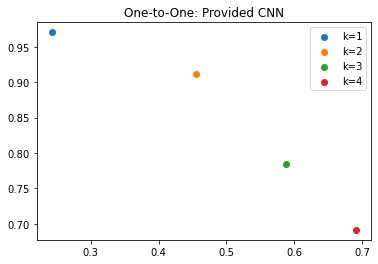

In [13]:
for k in range(1, 5):
    exec("top_%davg= np.mean(np.array(top_%d), axis=0)" % (k, k))

plt.figure()
for k in range(1, 5):
    exec("plt.scatter(top_%davg[1], top_%davg[0], label='k=%d')" % (k, k, k))  
    
plt.legend()
plt.title('One-to-One: Provided CNN')
plt.show()